In [2]:
import numpy as np

# Load the array (shape: 64, 64, 819, 300)
gt = np.load('../input/gt_func_train_1.npy')

# Step 1: bring the 3rd and 4th dims to the front so we can treat each slice as an image
# After transpose, shape will be (819, 300, 64, 64)
gt_seq = np.transpose(gt, (2, 3, 0, 1))

# Step 2: collapse the first two dims (819 × 300) into one long sequence of images
# The order is preserved: for i in 0..818, for j in 0..299 → index = i*300 + j
images = gt_seq.reshape(-1, gt.shape[0], gt.shape[1])

print('Resulting sequence shape:', images.shape)  # (819*300, 64, 64)

# Now `images[k]` is the k-th 64×64 image in the original order.


Resulting sequence shape: (245700, 64, 64)


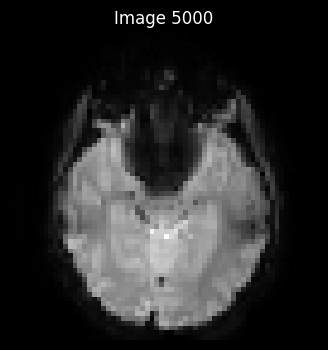

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(4, 4))
plt.imshow(images[5000], cmap='gray')
plt.title(f'Image {5000}')
plt.axis('off')

plt.show()

In [18]:
import math
import numpy as np
import cv2

def calculate_psnr(img1, img2):
    """Compute PSNR between two uint8 images."""
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    return float('inf') if mse == 0 else 20 * math.log10(255.0 / math.sqrt(mse))

def _ssim2d(ch1, ch2):
    """Compute SSIM for a single-channel 2D image."""
    C1 = (0.01*255)**2
    C2 = (0.03*255)**2
    ch1 = ch1.astype(np.float64)
    ch2 = ch2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.T)
    mu1 = cv2.filter2D(ch1, -1, window)[5:-5,5:-5]
    mu2 = cv2.filter2D(ch2, -1, window)[5:-5,5:-5]
    mu1_sq, mu2_sq = mu1**2, mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(ch1**2, -1, window)[5:-5,5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(ch2**2, -1, window)[5:-5,5:-5] - mu2_sq
    sigma12 = cv2.filter2D(ch1*ch2, -1, window)[5:-5,5:-5] - mu1_mu2
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2)) / ((mu1_sq+mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    """Compute SSIM between two images (grayscale or RGB)."""
    if img1.ndim == 2:
        return _ssim2d(img1, img2)
    elif img1.ndim == 3 and img1.shape[2] == 3:
        return float(np.mean([_ssim2d(img1[:,:,c], img2[:,:,c]) for c in range(3)]))
    else:
        raise ValueError("Unsupported image dimensions for SSIM.")

def normalize_to_uint8(arr):
    """Scale a float array to [0,255] uint8."""
    a = arr.astype(np.float64)
    a -= a.min()
    if a.max() != 0:
        a /= a.max()
    return (a*255).round().astype(np.uint8)

# ─── Configuration ─────────────────────────────────────────────────────────────
GT_INPUT_PATH = '../input/gt_func_train_1.npy'  # path to GT .npy
DENOISED_INPUT_PATH = '../input/noisy_func_train_1.npy'  # path to GT .npy

GT_PATH = GT_INPUT_PATH
SR_PATH = DENOISED_INPUT_PATH

# ─── Load as memory-mapped arrays ───────────────────────────────────────────────
gt = np.load(GT_PATH, mmap_mode='r')  # shape (64, 64, 819, 300)
sr = np.load(SR_PATH, mmap_mode='r')

# ─── Batch-wise Loop ───────────────────────────────────────────────────────────
d0, d1, d2, d3 = gt.shape
total_psnr = 0.0
total_ssim = 0.0
count = 0

for i in range(d2):
    for j in range(d3):
        slice_gt = normalize_to_uint8(gt[:, :, i, j])
        slice_sr = normalize_to_uint8(sr[:, :, i, j])
        total_psnr += calculate_psnr(slice_sr, slice_gt)
        total_ssim += calculate_ssim(slice_sr, slice_gt)
        count += 1
        if count % 10000 == 0 or (i == d2-1 and j == d3-1):
            print(f"Processed {count}/{d2*d3} slices")
            
            avg_psnr = total_psnr / count
            avg_ssim = total_ssim / count
            print("-------------------------------")
            print(f"Average PSNR: {avg_psnr:.4f}")
            print(f"Average SSIM: {avg_ssim:.4f}")
            print("-------------------------------")

# ─── Final Averages ────────────────────────────────────────────────────────────
avg_psnr = total_psnr / count
avg_ssim = total_ssim / count

print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")


Processed 10000/245700 slices
-------------------------------
Average PSNR: 20.3908
Average SSIM: 0.5184
-------------------------------
Processed 20000/245700 slices
-------------------------------
Average PSNR: 20.3950
Average SSIM: 0.5014
-------------------------------
Processed 30000/245700 slices
-------------------------------
Average PSNR: 20.3093
Average SSIM: 0.4868
-------------------------------


KeyboardInterrupt: 

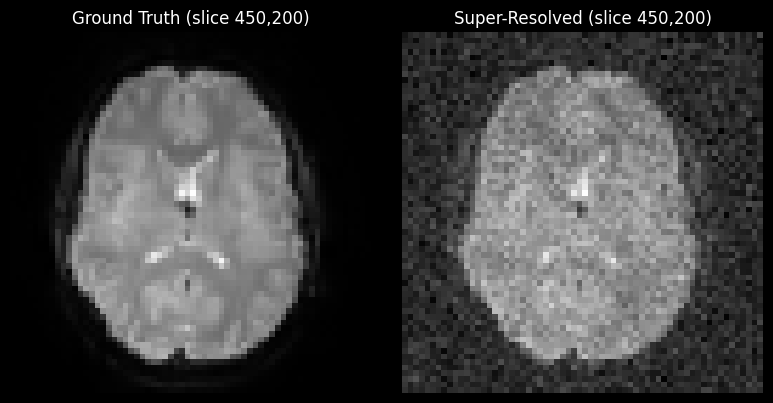

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Load the GT and SR volumes (memory-mapped to avoid large RAM usage)
gt = np.load('../input/gt_func_train_1.npy', mmap_mode='r')       # shape: (64,64,819,300)
sr = np.load('../input/noisy_func_train_1.npy', mmap_mode='r')     # same shape

# Select a specific slice by indices along the 3rd and 4th dimensions
i, j = 450, 200  # you can change these to view different slices

# Extract one 64×64 slice from each volume
gt_slice = gt[:, :, i, j]
sr_slice = sr[:, :, i, j]

def normalize_to_uint8(arr):
    """
    Normalize a floating-point array to the uint8 range [0,255].
    1) Shift by minimum to make values ≥0
    2) Divide by max to scale into [0,1]
    3) Multiply by 255 and round
    """
    a = arr.astype(np.float64)
    a -= a.min()
    max_val = a.max()
    if max_val != 0:
        a /= max_val
    return (a * 255.0).round().astype(np.uint8)

# Normalize for visualization
gt_img = normalize_to_uint8(gt_slice)
sr_img = normalize_to_uint8(sr_slice)

# Plot GT vs. SR side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(gt_img, cmap='gray')
axes[0].set_title(f'Ground Truth (slice {i},{j})')
axes[0].axis('off')
axes[1].imshow(sr_img, cmap='gray')
axes[1].set_title(f'Super-Resolved (slice {i},{j})')
axes[1].axis('off')
plt.tight_layout()
plt.show()
